In [1]:
# Setup dependencies (as taken from assignment 6)
import os
import math
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models

from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from joblib import load
import graycode

from pytorch_forecasting.metrics import QuantileLoss

#Additional Setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard

# Load data

In [2]:
df = pd.read_csv('day_ahead.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)
df

,Day-ahead Price [EUR/MWh],time,tempC,windspeedKmph,winddirDegree,precipMM,humidity,pressure
datetime,,,,,,,,
2015-01-05 00:00:00,-0.243620,2400,-1.722376,-0.422598,0.563889,0.000000,0.96,2.163731
2015-01-05 01:00:00,-0.316395,100,-1.722376,-0.297098,0.572222,0.000000,0.96,2.058525
2015-01-05 02:00:00,-0.439933,200,-1.722376,-0.171598,0.580556,0.000000,0.96,2.058525
2015-01-05 03:00:00,-0.625914,300,-1.722376,-0.046098,0.588889,0.000000,0.96,1.953318
2015-01-05 04:00:00,-0.626363,400,-1.722376,-0.171598,0.575000,0.000000,0.96,1.953318
...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,0.877205,1900,-1.130468,-0.673599,0.602778,0.054545,0.94,-1.728907
2020-12-31 20:00:00,0.665169,2000,-1.130468,-0.422598,0.625000,0.036364,0.93,-1.728907
2020-12-31 21:00:00,0.469755,2100,-1.130468,-0.171598,0.650000,0.054545,0.93,-1.623701


In [4]:
dayahead_scaler = load('dayahead_scaler.bin')

                     Day-ahead Price [EUR/MWh]  time     tempC  windspeedKmph  \
datetime                                                                        
2015-01-05 00:00:00                  -0.243620  2400 -1.722376      -0.422598   
2015-01-05 01:00:00                  -0.316395   100 -1.722376      -0.297098   
2015-01-05 02:00:00                  -0.439933   200 -1.722376      -0.171598   
2015-01-05 03:00:00                  -0.625914   300 -1.722376      -0.046098   
2015-01-05 04:00:00                  -0.626363   400 -1.722376      -0.171598   
...                                        ...   ...       ...            ...   
2020-12-31 19:00:00                   0.877205  1900 -1.130468      -0.673599   
2020-12-31 20:00:00                   0.665169  2000 -1.130468      -0.422598   
2020-12-31 21:00:00                   0.469755  2100 -1.130468      -0.171598   
2020-12-31 22:00:00                   0.443699  2200 -1.278445      -0.422598   
2020-12-31 23:00:00         

# Time variable

In [5]:
time = (df['time'].values/100).astype(int)

In [6]:
# incremental representation of time
time_increment = time/10

In [7]:
# gray code binary
time_gray_code = np.empty([len(time), 5])
for i in range(len(time)):
    gray_code_str = '{:05b}'.format(graycode.tc_to_gray_code(time[i]))
    time_gray_code[i] = np.array(list(gray_code_str)).astype(np.int8)

In [8]:
# mutually exclusive binary representation
time_exclusive = np.zeros([len(time), 24])
for i in range(len(time)):
    time_exclusive[i][time[i] - 1] = 1
time_exclusive = time_exclusive[:,::-1] # reverse array to correspond to binary representation

# Feature Engineering for Time Related Variables

In [9]:
time_exclusive

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [10]:
# no time variable
df0 = df.drop(columns=['time'])

In [11]:
# make copies of original dataset
df1 = df0.copy()
df2 = df0.copy()
df3 = df0.copy()

In [12]:
# incremental time representation
df1['time_increment'] = time_increment
df1['dow_sin'] = np.sin(df1.index.dayofweek*(2.*np.pi/7))
df1['dow_cos'] = np.cos(df1.index.dayofweek*(2.*np.pi/7))

df1['mnth_sin'] = np.sin((df1.index.month-1)*(2.*np.pi/12))
df1['mnth_cos'] = np.cos((df1.index.month-1)*(2.*np.pi/12))

df1['week_sin'] = np.sin((pd.Int64Index(df1.index.isocalendar().week)-1)*(2.*np.pi/53))
df1['week_cos'] = np.cos((pd.Int64Index(df1.index.isocalendar().week)-1)*(2.*np.pi/53))

# df1['hour_sine'] = np.sin((df1.index.hour)*(2.*np.pi/24))
# df1['hour_cos'] = np.cos((df1.index.hour)*(2.*np.pi/24))

display(df1)





,Day-ahead Price [EUR/MWh],tempC,windspeedKmph,winddirDegree,precipMM,humidity,pressure,time_increment,dow_sin,dow_cos,mnth_sin,mnth_cos,week_sin,week_cos
datetime,,,,,,,,,,,,,,
2015-01-05 00:00:00,-0.243620,-1.722376,-0.422598,0.563889,0.000000,0.96,2.163731,2.4,0.000000,1.000000,0.0,1.000000,0.118273,0.992981
2015-01-05 01:00:00,-0.316395,-1.722376,-0.297098,0.572222,0.000000,0.96,2.058525,0.1,0.000000,1.000000,0.0,1.000000,0.118273,0.992981
2015-01-05 02:00:00,-0.439933,-1.722376,-0.171598,0.580556,0.000000,0.96,2.058525,0.2,0.000000,1.000000,0.0,1.000000,0.118273,0.992981
2015-01-05 03:00:00,-0.625914,-1.722376,-0.046098,0.588889,0.000000,0.96,1.953318,0.3,0.000000,1.000000,0.0,1.000000,0.118273,0.992981
2015-01-05 04:00:00,-0.626363,-1.722376,-0.171598,0.575000,0.000000,0.96,1.953318,0.4,0.000000,1.000000,0.0,1.000000,0.118273,0.992981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,0.877205,-1.130468,-0.673599,0.602778,0.054545,0.94,-1.728907,1.9,0.433884,-0.900969,-0.5,0.866025,-0.118273,0.992981
2020-12-31 20:00:00,0.665169,-1.130468,-0.422598,0.625000,0.036364,0.93,-1.728907,2.0,0.433884,-0.900969,-0.5,0.866025,-0.118273,0.992981
2020-12-31 21:00:00,0.469755,-1.130468,-0.171598,0.650000,0.054545,0.93,-1.623701,2.1,0.433884,-0.900969,-0.5,0.866025,-0.118273,0.992981


In [13]:
# gray code time representation
time_gray_code.shape
for i in range(time_gray_code.shape[1]):
    df2['gc_'+str(i)] = time_gray_code[:,i]

In [14]:
# mutually exclusive time representation
for i in range(time_exclusive.shape[1]):
    df3['ex_'+str(i)] = time_exclusive[:,i]

# Create Torch dataset

In [15]:
def create_torch_dataset(df, seq_length):
    
    delta = pd.Timedelta(seq_length, unit ='h')
    # define 1 hour object for convenience when using datetime as index in the dataframe to not include the last item
    hours_12 = pd.Timedelta(12, unit ='h') # used mostly for empty 12 hours 
    hour = pd.Timedelta(1, unit ='h')
    day = pd.Timedelta(1, unit ='d')
    
    ### creating training dataset
    train_y_start = dt.datetime(2015, 1, 5, 0, 0) + (delta+hours_12).ceil('1d')
    train_end = dt.datetime(2020, 10, 31, 23, 0)

    train_x = []
    train_y = []
    while train_y_start + day - hour <= train_end:
        train_x_start = train_y_start - delta - hours_12


        #print(train_x_start, train_y_start)
        train_x.append(df[train_x_start:train_x_start+delta - hour].values)
        train_y.append(df[train_y_start:train_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)

        train_y_start += day

    train_x = np.asarray(train_x)
    train_y = np.asarray(train_y)
    
    
    ### creating validation dataset
    val_y_start = dt.datetime(2020, 11, 1, 0, 0)
    val_end = dt.datetime(2020, 11, 30, 23, 0)

    val_x = []
    val_y = []
    while val_y_start + day - hour <= val_end:
        val_x_start = val_y_start - delta - hours_12

        val_x.append(df[val_x_start:val_x_start+delta - hour].values)
        val_y.append(df[val_y_start:val_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)

        val_y_start += day

    val_x = np.asarray(val_x)
    val_y = np.asarray(val_y)
    
    ### creating testing dataset
    test_y_start = dt.datetime(2020, 12, 1, 0, 0)
    test_end = dt.datetime(2020, 12, 31, 23, 0)

    test_x = []
    test_y = []
    while test_y_start + day - hour <= test_end:
        test_x_start = test_y_start - delta - hours_12

        test_x.append(df[test_x_start:test_x_start+delta - hour].values)
        test_y.append(df[test_y_start:test_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)

        test_y_start += day

    test_x = np.asarray(test_x)
    test_y = np.asarray(test_y)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

# Define BLSTM model

In [16]:
class BLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, quantiles):
        super(BLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_dim*2, output_dim) # multiply hidden_dim by 2 because bidirectional
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        self.out_shape = len(quantiles)
        
        final_layers = [
            nn.Linear(hidden_dim*2, output_dim) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def add_noise_to_weights(self):
        with torch.no_grad():
            # add noise to lstm weights
            for weights in model.lstm._all_weights:
                for weight in weights:
                    noise = torch.normal(0, 0.01, size=self.lstm._parameters[weight].size())
                    self.lstm._parameters[weight].add_(noise)
            # add noise to linear layer weights, most likely unnecessary
#             for layer in self.final_layers:
#                 if hasattr(layer, 'weight'):
#                     noise = torch.normal(0, 0.05, size=layer.weight.size())
#                     layer.weight.add_(noise)

        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_() #hidden layer output
        # Initialize cell state
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_() 
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
#         _out = self.fc(out[:, -1, :])
        
        return torch.stack([layer(out[:, -1, :]) for layer in self.final_layers], dim=1)

# (Hyper)parameters

In [17]:
# hyperparameters to set
seq_lengths = [12, 24, 36, 48, 72]
dfs = [df1,df2,df3,df0]
hidden_dim_ = [4, 8, 16, 32, 64, 128] # no. of dimension in hidden layer
num_layers_ = [1, 2, 3, 4] # no of hidden layers 


# predetermined parameters
output_dim = 24 
num_epochs = 500
batch_size = 64
quantiles = [.01,0.05, 0.10,0.25, .5, 0.75, 0.90, 0.95, .99]
patience = 10 # for early stopping

## Training loop to find the best Hyperparameters

In [18]:
# save average validation loss of 10 (patience value) epochs since the best performance, which are the last 10
validation_performance = np.zeros((len(dfs), len(seq_lengths), len(hidden_dim_), len(num_layers_)))

for df_type, df in enumerate(dfs):
    for seq_idx, seq in enumerate(seq_lengths):
        
        train_x, train_y, val_x, val_y, test_x, test_y = create_torch_dataset(df, seq)
                
        # create tensor objects
        x_train = torch.from_numpy(train_x).float()
        y_train = torch.from_numpy(train_y).float()
        x_val = torch.from_numpy(val_x).float()
        y_val = torch.from_numpy(val_y).float()
        x_test = torch.from_numpy(test_x).float()
        y_test = torch.from_numpy(test_y).float()

        # create training batch
        train_data = []
        for i in range(len(x_train)):
            train_data.append([x_train[i], y_train[i]])

        trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

        # other parameters for initializing the model
        num_train = x_train.shape[0]
        input_dim = x_train.shape[2]
        
        
        for hidden_idx, hidden_dim in enumerate(hidden_dim_):
            for layer_idx, num_layers in enumerate(num_layers_):
                print()
                print()
                print("starting time var type: ", df_type, " sequence length: ", 
                      seq, " num layers: ", num_layers, " hidden dim: ", hidden_dim)

                criterion = QuantileLoss(quantiles)
                model = BLSTM(input_dim=input_dim, 
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim, 
                              num_layers=num_layers, 
                              quantiles=quantiles)
                #print(model)
                optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

                # Initialize early stopping variables
                val_loss_best = np.Inf
                patience_cnt = 0
                
                
                
            
                val_losses = []
                for t in range(num_epochs): 
                    
                    err = []
                    
                    # training
                    for batch in trainloader:
                        inputs, outputs = batch
                        model.add_noise_to_weights() # adding noise to lstm weights during the training
                        y_train_pred = model(inputs)

                        loss = torch.mean(torch.sum(criterion.loss(torch.transpose(y_train_pred,1,2), outputs), dim=2))
                        optimiser.zero_grad()
                        loss.backward()
                        optimiser.step()
                        err.append(loss.item())

                    # validation
                    with torch.no_grad():
                        preds=model(x_val)
                        val_loss = torch.mean(torch.sum(criterion.loss(torch.transpose(preds,1,2), y_val), dim=2)).item()
                        val_losses.append(val_loss)


                    if val_loss < val_loss_best:
                        val_loss_best = val_loss
                        patience_cnt = 0
                    else:
                        patience_cnt +=1
                        if patience_cnt == patience:
                            print("Early stopping: Epoch ", t+1, "training loss: ", sum(err)/len(err), "validation loss: ", val_loss)
                            break
                    
                    if (t+1) % 10 == 0:
                        print("Epoch ", t+1, "training loss: ", sum(err)/len(err), "validation loss: ", val_loss)
                    
                validation_performance[df_type, seq_idx, hidden_idx, layer_idx] = sum(val_losses[-patience:])/patience

print()
print()
print("Done!")



starting time var type:  0  sequence length:  12  num layers:  1  hidden dim:  4
Epoch  10 training loss:  0.902879502843408 validation loss:  0.7510492205619812
Epoch  20 training loss:  0.8190378827207229 validation loss:  0.7273987531661987
Epoch  30 training loss:  0.7823410560103023 validation loss:  0.6798135042190552
Early stopping: Epoch  39 training loss:  0.7811141014099121 validation loss:  0.7068829536437988


starting time var type:  0  sequence length:  12  num layers:  2  hidden dim:  4
Epoch  10 training loss:  0.918805900742026 validation loss:  0.7849859595298767
Epoch  20 training loss:  0.8265514820814133 validation loss:  0.7007933855056763
Epoch  30 training loss:  0.8018950872561511 validation loss:  0.6935615539550781
Epoch  40 training loss:  0.7620781721437678 validation loss:  0.6857701539993286
Epoch  50 training loss:  0.7482082677238128 validation loss:  0.6673474907875061
Early stopping: Epoch  54 training loss:  0.7510039446985021 validation loss:  0.6

Epoch  10 training loss:  0.7935062085880953 validation loss:  0.6851615309715271
Epoch  20 training loss:  0.6909015871146146 validation loss:  0.6495944261550903
Epoch  30 training loss:  0.6137618869543076 validation loss:  0.7343472242355347
Early stopping: Epoch  31 training loss:  0.6176664092961479 validation loss:  0.6693798303604126


starting time var type:  0  sequence length:  12  num layers:  3  hidden dim:  64
Epoch  10 training loss:  0.8660764965940925 validation loss:  0.7637301087379456
Epoch  20 training loss:  0.7383555138812345 validation loss:  0.6723616719245911
Epoch  30 training loss:  0.6635187215664807 validation loss:  0.61440110206604
Early stopping: Epoch  36 training loss:  0.6497217977748198 validation loss:  0.7427603602409363


starting time var type:  0  sequence length:  12  num layers:  4  hidden dim:  64
Epoch  10 training loss:  1.1654007014106302 validation loss:  0.7870563864707947
Epoch  20 training loss:  0.7959122920737547 validation loss:  0

Epoch  40 training loss:  0.698210687321775 validation loss:  0.711495041847229
Epoch  50 training loss:  0.6852093216250924 validation loss:  0.6454149484634399
Epoch  60 training loss:  0.6437134348294314 validation loss:  0.6697590351104736
Early stopping: Epoch  63 training loss:  0.6413366382612902 validation loss:  0.6827017068862915


starting time var type:  0  sequence length:  24  num layers:  1  hidden dim:  32
Epoch  10 training loss:  0.7902769604149986 validation loss:  0.646935760974884
Epoch  20 training loss:  0.717076021082261 validation loss:  0.64399254322052
Epoch  30 training loss:  0.6683980743674671 validation loss:  0.6593102216720581
Early stopping: Epoch  31 training loss:  0.660275977324037 validation loss:  0.6574652791023254


starting time var type:  0  sequence length:  24  num layers:  2  hidden dim:  32
Epoch  10 training loss:  0.8005446782883476 validation loss:  0.6550559401512146
Epoch  20 training loss:  0.7107772932333105 validation loss:  0.6259

Epoch  30 training loss:  0.7094797299188726 validation loss:  0.6143156290054321
Early stopping: Epoch  40 training loss:  0.6974457993226892 validation loss:  0.6272695660591125


starting time var type:  0  sequence length:  36  num layers:  2  hidden dim:  8
Epoch  10 training loss:  0.8913304060697556 validation loss:  0.7275350093841553
Epoch  20 training loss:  0.7553738601067487 validation loss:  0.6943588852882385
Epoch  30 training loss:  0.708472490310669 validation loss:  0.6750785708427429
Early stopping: Epoch  36 training loss:  0.6937823672504986 validation loss:  0.6898279190063477


starting time var type:  0  sequence length:  36  num layers:  3  hidden dim:  8
Epoch  10 training loss:  0.906677807078642 validation loss:  0.7190710306167603
Epoch  20 training loss:  0.7792003908578087 validation loss:  0.7009495496749878
Epoch  30 training loss:  0.7160208698581246 validation loss:  0.6494200229644775
Early stopping: Epoch  36 training loss:  0.697530530831393 valida

Epoch  10 training loss:  1.3813472793382757 validation loss:  0.9776900410652161
Epoch  20 training loss:  1.3899550858665914 validation loss:  0.966192364692688
Early stopping: Epoch  26 training loss:  1.4364068630863638 validation loss:  1.4766427278518677


starting time var type:  0  sequence length:  48  num layers:  1  hidden dim:  4
Epoch  10 training loss:  0.8538095398860819 validation loss:  0.7408217787742615
Epoch  20 training loss:  0.7862406916478101 validation loss:  0.7028325200080872
Epoch  30 training loss:  0.7444098670693005 validation loss:  0.658668577671051
Epoch  40 training loss:  0.7243887773331474 validation loss:  0.6289126873016357
Epoch  50 training loss:  0.7183282752247417 validation loss:  0.645253598690033
Epoch  60 training loss:  0.7152325265547809 validation loss:  0.6357452273368835
Early stopping: Epoch  61 training loss:  0.7180082824300317 validation loss:  0.6413827538490295


starting time var type:  0  sequence length:  48  num layers:  2  

Epoch  40 training loss:  0.684442813782131 validation loss:  0.6285338997840881
Epoch  50 training loss:  0.6447649633183199 validation loss:  0.7199521660804749
Early stopping: Epoch  58 training loss:  0.6250010921674616 validation loss:  0.7253063917160034


starting time var type:  0  sequence length:  48  num layers:  1  hidden dim:  64
Epoch  10 training loss:  0.7996757959618288 validation loss:  0.6457047462463379
Epoch  20 training loss:  0.7167727403780993 validation loss:  0.6638631224632263
Epoch  30 training loss:  0.6441692017457065 validation loss:  0.6788570880889893
Early stopping: Epoch  34 training loss:  0.6229779176852283 validation loss:  0.6777991652488708


starting time var type:  0  sequence length:  48  num layers:  2  hidden dim:  64
Epoch  10 training loss:  0.7929527724490446 validation loss:  0.6916256546974182
Epoch  20 training loss:  0.7423081143813974 validation loss:  0.6477549076080322
Early stopping: Epoch  28 training loss:  0.642723378889701 val

Early stopping: Epoch  35 training loss:  0.6597238542402492 validation loss:  0.6776800155639648


starting time var type:  0  sequence length:  72  num layers:  3  hidden dim:  16
Epoch  10 training loss:  0.897761765648337 validation loss:  0.7559142112731934
Epoch  20 training loss:  0.7875899874112186 validation loss:  0.7008247375488281
Epoch  30 training loss:  0.7375079963137122 validation loss:  0.6816404461860657
Epoch  40 training loss:  0.6748160430613686 validation loss:  0.5957940220832825
Early stopping: Epoch  50 training loss:  0.6305563826771343 validation loss:  0.5979402661323547


starting time var type:  0  sequence length:  72  num layers:  4  hidden dim:  16
Epoch  10 training loss:  1.002523373155033 validation loss:  0.8025104999542236
Epoch  20 training loss:  0.8290360657607808 validation loss:  0.7838484048843384
Epoch  30 training loss:  0.7801270888132208 validation loss:  0.6742231845855713
Epoch  40 training loss:  0.6961091283489677 validation loss:  0

## get best hyperparameters

In [19]:
performance = validation_performance

In [21]:
# get the hyperparameter setting of model with lowest validation loss
best = np.amin(performance)
result = np.where(performance == best)

In [22]:
print(best)
print(result)

0.620872575044632
(array([0]), array([4]), array([3]), array([2]))


# Train model with adjusted hyperparameters

In [45]:
# New hyperparameters

seq = 72
df = df1
hidden_dim = 32 # no. of dimension in hidden layer
num_layers = 3 # no of hidden layers 


# predetermined parameters
output_dim = 24 
num_epochs = 500
batch_size = 64
quantiles = [.01,0.05, 0.10,0.25, .5, 0.75, 0.90, 0.95, .99]
patience = 10 # for early stopping

In [46]:
train_x, train_y, val_x, val_y, test_x, test_y = create_torch_dataset(df, seq)
print(train_x.shape)

(2123, 72, 14)


In [47]:
train_x, train_y, val_x, val_y, test_x, test_y = create_torch_dataset(df, seq)
                
# create tensor objects
x_train = torch.from_numpy(train_x).float()
y_train = torch.from_numpy(train_y).float()
x_val = torch.from_numpy(val_x).float()
y_val = torch.from_numpy(val_y).float()
x_test = torch.from_numpy(test_x).float()
y_test = torch.from_numpy(test_y).float()

# create training batch
train_data = []
for i in range(len(x_train)):
    train_data.append([x_train[i], y_train[i]])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

# other parameters for initializing the model
num_train = x_train.shape[0]
input_dim = x_train.shape[2]

print("starting sequence length: ", 
      seq, " num layers: ", num_layers, " hidden dim: ", hidden_dim)

criterion = QuantileLoss(quantiles)
model = BLSTM(input_dim=input_dim, 
              hidden_dim=hidden_dim, 
              output_dim=output_dim, 
              num_layers=num_layers, 
              quantiles=quantiles)
#print(model)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Initialize early stopping variables
val_loss_best = np.Inf
patience_cnt = 0




val_losses = []
for t in range(num_epochs): 

    err = []

    # training
    for batch in trainloader:
        inputs, outputs = batch
        model.add_noise_to_weights() # adding noise to lstm weights during the training
        y_train_pred = model(inputs)

        loss = torch.mean(torch.sum(criterion.loss(torch.transpose(y_train_pred,1,2), outputs), dim=2))
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        err.append(loss.item())

    # validation
    with torch.no_grad():
        preds=model(x_val)
        val_loss = torch.mean(torch.sum(criterion.loss(torch.transpose(preds,1,2), y_val), dim=2)).item()
        val_losses.append(val_loss)


    if val_loss < val_loss_best:
        val_loss_best = val_loss
        patience_cnt = 0
    else:
        patience_cnt +=1
        if patience_cnt == patience:
            print("Early stopping: Epoch ", t+1, "training loss: ", sum(err)/len(err), "validation loss: ", val_loss)
            break

    if (t+1) % 2 == 0:
        print("Epoch ", t+1, "training loss: ", sum(err)/len(err), "validation loss: ", val_loss)


starting sequence length:  72  num layers:  3  hidden dim:  32
Epoch  2 training loss:  1.4548639514866997 validation loss:  1.0623358488082886
Epoch  4 training loss:  1.265625504886403 validation loss:  0.8538031578063965
Epoch  6 training loss:  1.0354386673254126 validation loss:  0.749950647354126
Epoch  8 training loss:  0.9121979527613696 validation loss:  0.7919166684150696
Epoch  10 training loss:  0.8747316257042044 validation loss:  0.7624499201774597
Epoch  12 training loss:  0.8283506526666529 validation loss:  0.751462996006012
Epoch  14 training loss:  0.7997766706873389 validation loss:  0.7199062705039978
Epoch  16 training loss:  0.7800561601624769 validation loss:  0.696141242980957
Epoch  18 training loss:  0.7640441358089447 validation loss:  0.7124778628349304
Epoch  20 training loss:  0.7374137850368724 validation loss:  0.6304160952568054
Epoch  22 training loss:  0.709855326834847 validation loss:  0.6369980573654175
Epoch  24 training loss:  0.7188414922531914

# Test performance and Results

In [49]:
# Make the prediction on the meshed x-axis
model.eval()
with torch.no_grad():
    preds=model(x_test)

In [50]:
preds = dayahead_scaler.inverse_transform(preds)

In [51]:
test_df = df[dt.datetime(2020, 12, 1, 0, 0):dt.datetime(2020, 12, 31, 23, 0)][['Day-ahead Price [EUR/MWh]']]
test_df[test_df.columns] = dayahead_scaler.inverse_transform(test_df.values)
for i in range(preds.shape[1]):
    y=preds[:,i,:]
    test_df[str(i)]=y.flatten()

In [52]:
preds_test = torch.from_numpy(np.transpose(preds,(0,2,1)))
y_test_price = torch.from_numpy(test_df['Day-ahead Price [EUR/MWh]'].values.reshape((-1, 24)))

# quantile loss in term of dayahead price (not normalize or standardize)
torch.mean(torch.sum(criterion.loss(preds_test, y_test_price), dim=2)).item()

28.171515058749808

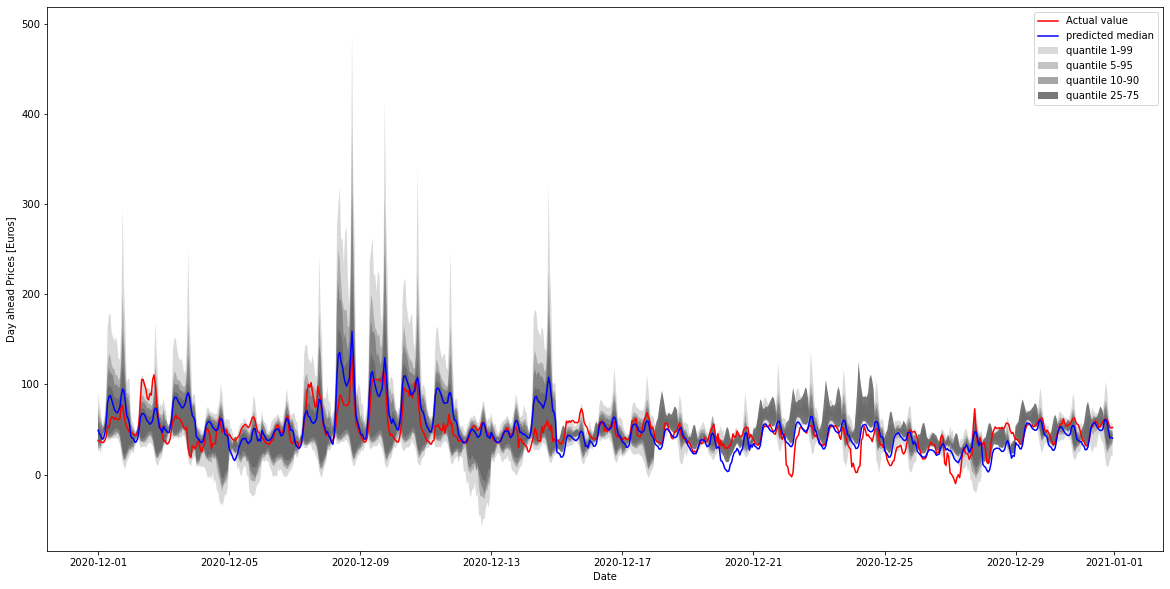

In [80]:
# plot whole data

fig = plt.figure(figsize=(20,10))
plt.plot(test_df.index, test_df['Day-ahead Price [EUR/MWh]'].values, 'r', label='Actual value')
plt.plot(test_df.index, test_df['4'].values.flatten(), 'b', label='predicted median')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['8'].values.flatten(), test_df['0'].values.flatten()]),
         alpha=.25, fc='dimgray', ec='None', label='quantile 1-99')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['7'].values.flatten(), test_df['1'].values.flatten()]),
         alpha=.4, fc='dimgray', ec='None', label='quantile 5-95')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['6'].values.flatten(), test_df['2'].values.flatten()]),
         alpha=.6, fc='dimgray', ec='None', label='quantile 10-90')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['5'].values.flatten(), test_df['3'].values.flatten()]),
         alpha=0.9, fc='dimgray', ec='None', label='quantile 25-75')

plt.xlabel('Date')
plt.ylabel('Day ahead Prices [Euros]')
plt.legend(loc='upper right')
plt.savefig('30day_tuned_result.png')
plt.show()



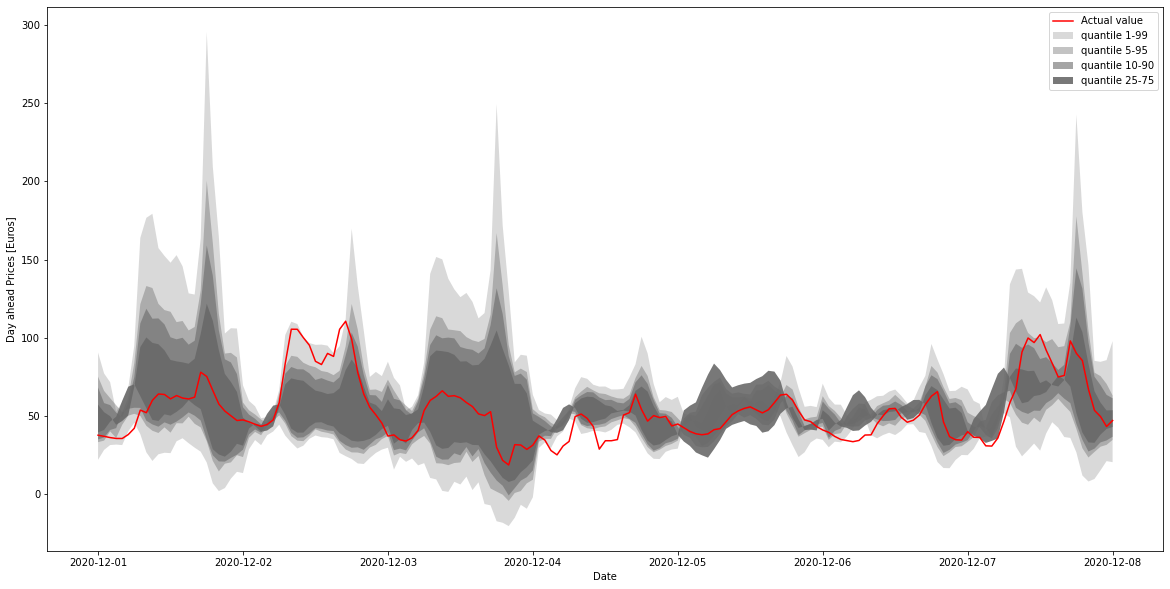

In [81]:
# plot first 7 days

part_df = test_df[dt.datetime(2020, 12, 1, 0, 0):dt.datetime(2020, 12, 8, 0, 0)]
part_df

fig = plt.figure(figsize=(20,10))
plt.plot(part_df.index, part_df['Day-ahead Price [EUR/MWh]'].values, 'r', label='Actual value')
# plt.plot(part_df.index, part_df['4'].values.flatten(), 'b', label='predicted median')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['8'].values.flatten(), part_df['0'].values.flatten()]),
         alpha=.25, fc='dimgray', ec='None', label='quantile 1-99')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['7'].values.flatten(), part_df['1'].values.flatten()]),
         alpha=.4, fc='dimgray', ec='None', label='quantile 5-95')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['6'].values.flatten(), part_df['2'].values.flatten()]),
         alpha=.6, fc='dimgray', ec='None', label='quantile 10-90')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['5'].values.flatten(), part_df['3'].values.flatten()]),
         alpha=0.9, fc='dimgray', ec='None', label='quantile 25-75')

plt.xlabel('Date')
plt.ylabel('Day ahead Prices [Euros]')
plt.legend(loc='upper right')
plt.savefig('7day_tuned_result.png')
plt.show()

That's it folks